In [1]:
!pip install -U tqdm kagglehub umap-learn albumentations pydantic

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
import os
from torchvision.io import read_image
import random
import wandb
from tqdm.notebook import tqdm
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_recall_fscore_support, confusion_matrix, silhouette_score, adjusted_mutual_info_score, normalized_mutual_info_score
import cv2
from sklearn.cluster import KMeans, DBSCAN
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from PIL import Image
import kagglehub
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
# import umap

In [3]:
#  Pins Dataset of almost 17534 images and 105 identities
class PinsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        super().__init__()
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}
        
        # Get all person directories and sort them
        self.person_dirs = sorted([
            d for d in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, d))
        ])
        
        # Create mapping from person name to label index
        for idx, person_dir in enumerate(self.person_dirs):
            self.class_to_idx[person_dir] = idx
        
        # Collect all image paths and labels
        for person_dir in self.person_dirs:
            person_path = os.path.join(root_dir, person_dir)
            person_images = [
                os.path.join(person_path, img)
                for img in os.listdir(person_path)
                if img.endswith(('.jpg', '.jpeg', '.png'))
            ]
            
            label = self.class_to_idx[person_dir]
            self.image_paths.extend(person_images)
            self.labels.extend([label] * len(person_images))
        
        # Create a dictionary mapping labels to their image paths
        self.label_to_images = {}
        for img, label in zip(self.image_paths, self.labels):
            if label not in self.label_to_images:
                self.label_to_images[label] = []
            self.label_to_images[label].append(img)
        
        print(f"Loaded dataset with {len(self.person_dirs)} people and {len(self.image_paths)} images")


    def create_subset(self, indices):
        """
        Creates a new subset of the dataset based on given indices
        """
        subset = PinsDataset(self.root_dir, self.transform)
        subset.image_paths = [self.image_paths[i] for i in indices]
        subset.labels = [self.labels[i] for i in indices]
        
        # Rebuild label_to_images mapping for the subset
        subset.label_to_images = {}
        for img, label in zip(subset.image_paths, subset.labels):
            if label not in subset.label_to_images:
                subset.label_to_images[label] = []
            subset.label_to_images[label].append(img)
        
        print(f"Loaded subset dataset with {len(subset.label_to_images)} people and {len(subset.image_paths)} images")
            
        return subset
    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        anchor_path = self.image_paths[idx]
        anchor_label = self.labels[idx]        

        # anchor = read_image(anchor_path).float() / 255.0
        # if self.transform:
        #     anchor = self.transform(anchor)

        # Load image using PIL
        anchor = Image.open(anchor_path).convert('RGB')
        anchor = np.array(anchor)

        # Apply Albumentations transform
        if self.transform:
            augmented = self.transform(image=anchor)
            anchor = augmented['image']

        return anchor, anchor_label

# VGGFace2Dataset of almost 600000 images
class VGGFace2Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        self.person_dirs = [
            os.path.join(root_dir, person_dir)
            for person_dir in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, person_dir))
        ]
        
        for idx, person_dir in enumerate(self.person_dirs):
            images = [os.path.join(person_dir, img) for img in os.listdir(person_dir)]
            self.image_paths.extend(images)
            self.labels.extend([idx] * len(images))
        
        self.label_to_images = {}
        for img, label in zip(self.image_paths, self.labels):
            if label not in self.label_to_images:
                self.label_to_images[label] = []
            self.label_to_images[label].append(img)

        print(f"Loaded dataset with {len(self.person_dirs)} people and {len(self.image_paths)} images")


    def create_subset(self, indices):
        """
        Creates a new subset of the dataset based on given indices
        """
        subset = VGGFace2Dataset(self.root_dir, self.transform, self.a_p_n)
        subset.person_dirs = self.person_dirs
        subset.image_paths = [self.image_paths[i] for i in indices]
        subset.labels = [self.labels[i] for i in indices]
        
        # Rebuild label_to_images mapping for the subset
        subset.label_to_images = {}
        for img, label in zip(subset.image_paths, subset.labels):
            if label not in subset.label_to_images:
                subset.label_to_images[label] = []
            subset.label_to_images[label].append(img)

        print(f"Loaded subset dataset with {len(subset.label_to_images)} people and {len(subset.image_paths)} images")

        return subset

    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        anchor_path = self.image_paths[idx]
        anchor_label = self.labels[idx]
        
        # # Load and transform
        # anchor = read_image(anchor_path).float() / 255.0
        # if self.transform:
        #     anchor = self.transform(anchor)

        # Load image using PIL
        anchor = Image.open(anchor_path).convert('RGB')
        anchor = np.array(anchor)

        # Apply Albumentations transform
        if self.transform:
            augmented = self.transform(image=anchor)
            anchor = augmented['image']

        return anchor, anchor_label

Loaded dataset with 4605 people and 624215 images


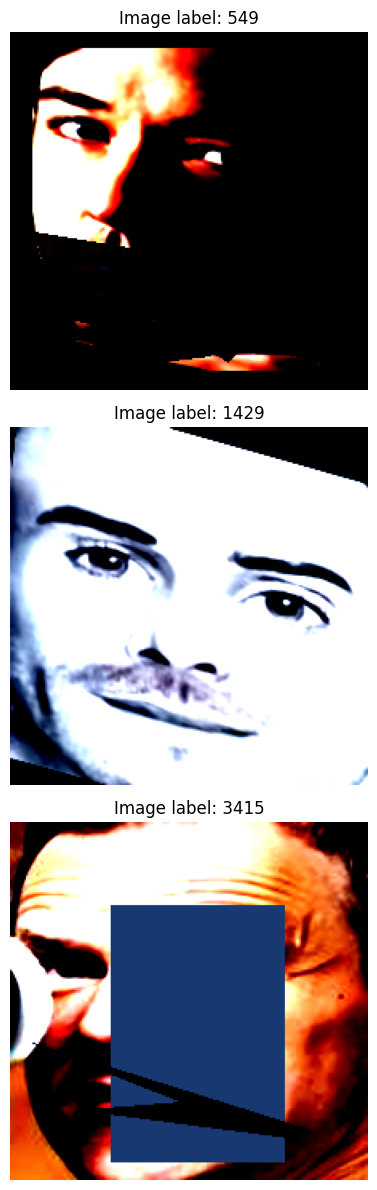

In [4]:
def visualize_random_pairs(dataset, n=5):
    pairs = [dataset[random.randint(0, len(dataset) - 1)] for _ in range(n)]
    fig, axes = plt.subplots(n, 1, figsize=(12, 4 * n))  # Change to n rows and 1 column

    for i, (img1, label) in enumerate(pairs):
        axes[i].imshow(img1.permute(1, 2, 0).numpy())
        axes[i].set_title(f"Image label: {label}")
        axes[i].axis('off')  # Optionally turn off the axis

    plt.tight_layout()
    plt.show()

# Augmentation and transforms - Enhanced data augmentation
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomApply([
#         transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
#         transforms.RandomRotation(10),
#         transforms.RandomHorizontalFlip(),
#     ], p=0.5),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])


transform_train = A.Compose([
    A.Resize(height=224, width=224),
    A.OneOf([
        A.Affine(scale=(0.85, 1.15),translate_percent=(-0.1, 0.1),rotate=(-15, 15),shear=(-10, 10),p=1.0),
        A.ElasticTransform(alpha=1.0,sigma=50.0,p=1.0),
        A.OpticalDistortion(distort_limit=0.05,mode='camera',p=1.0),
    ], p=0.5),
    A.OneOf([
        A.RandomResizedCrop(size=(224,224),scale=(0.08, 1.0),ratio=(0.9, 1.1),p=1.0),
        A.CropAndPad(percent=(-0.1, 0.1),p=1.0),
        A.CoarseDropout(num_holes_range=(1,2),hole_height_range=(0.1, 0.8), hole_width_range=(0.1, 0.8),fill=128,p=1.0),
    ], p=0.5),
    A.HorizontalFlip(p=0.5),
    # A.ShiftScaleRotate(shift_limit=0.05,scale_limit=0.05,rotate_limit=15,border_mode=cv2.BORDER_REFLECT_101,p=0.5),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.2,contrast_limit=0.2,p=1.0),
        A.RandomGamma(gamma_limit=(80, 120),p=1.0),
        A.HueSaturationValue(hue_shift_limit=10,sat_shift_limit=15,val_shift_limit=10,p=1.0),
        A.CLAHE(clip_limit=4.0,tile_grid_size=(8, 8),p=1.0),
    ], p=0.5),
    A.OneOf([
        A.RandomShadow(shadow_roi=(0, 0.5, 1.0, 1.0),num_shadows_limit=(1,3),p=1.0),
        A.RandomSunFlare(flare_roi=(0, 0, 1, 0.5),angle_range=(0, 1),num_flare_circles_range=(6, 10),src_radius=250,src_color=(255, 255, 255),p=1.0),
        A.RandomFog(fog_coef_range=(0.3, 1),alpha_coef=0.08,p=1.0),
    ], p=0.3),
    A.OneOf([
        A.GaussNoise(p=1.0),
        A.ISONoise(color_shift=(0.01, 0.05),intensity=(0.1, 0.5),p=1.0),
        A.ImageCompression(compression_type='jpeg', quality_range=(70, 100),p=1.0),
        A.GaussianBlur(blur_limit=(3, 7),p=1.0),
        A.MotionBlur(blur_limit=5,p=1.0),
    ], p=0.3),
    A.OneOf([
        A.GridDropout(ratio=0.1,unit_size_range=(8,16),random_offset=True,p=1.0),
        A.CoarseDropout(num_holes_range=(1,2),p=1.0),
    ], p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])



transform_val = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Initialize the dataset
root_dir = '/kaggle/input/vggface2-hq-cropped/VGGface2_HQ_cropped/VGGface2_HQ_cropped'
dataset = VGGFace2Dataset(root_dir, transform=transform_train)
# or this dataset pins
# root_dir = '/kaggle/input/pins-face-recognition/105_classes_pins_dataset'
# dataset = PinsDataset(root_dir, transform=transform_train)

visualize_random_pairs(dataset=dataset,n=3)

In [5]:
class ArcFaceLoss(nn.Module):
    """
    ArcFace Loss implementation with cosine margin for enhanced feature discrimination.
    Applies an angular margin penalty to the target logit 
        (20, 6, 14) --> (30.0, 0.5).
        (3) --> (45.0, 0.7)
    """
    def __init__(self, in_features, out_features, scale=45.0, margin=0.7, easy_margin=False):
        super(ArcFaceLoss, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.scale = scale
        self.margin = margin
        self.easy_margin = easy_margin
        
        # Weight parameter representing the prototype vectors
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
        
        # Pre-compute angular margin parameters
        self.cos_m = math.cos(margin)
        self.sin_m = math.sin(margin)
        self.th = math.cos(math.pi - margin)
        self.mm = math.sin(math.pi - margin) * margin

    def forward(self, input, label):
        # Normalize feature vectors
        x = F.normalize(input)
        # Normalize weights
        W = F.normalize(self.weight)
        
        # Compute cosine similarity
        cosine = F.linear(x, W)
        sine = torch.sqrt((1.0 - torch.pow(cosine, 2)).clamp(0, 1))
        
        # Add angular margin
        phi = cosine * self.cos_m - sine * self.sin_m
        
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        
        # Convert labels to one-hot encoding
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        
        # Apply margin to target classes only
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        
        # Scale logits
        output *= self.scale
        return output

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [7]:
class DeepResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(DeepResidualBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        
        out += residual
        out = F.relu(out)
        return out

In [8]:
class EnhancedFaceRecognitionModel(nn.Module):
    def __init__(self, num_classes, embedding_size=512, input_size=224):
        super(EnhancedFaceRecognitionModel, self).__init__()
        
        # Initial convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # Deep residual layers (total >30 conv layers)
        self.layer1 = self._make_layer(64, 64, 3, stride=1)      # 6 conv layers
        self.layer2 = self._make_layer(64, 128, 4, stride=2)     # 8 conv layers
        self.layer3 = self._make_layer(128, 256, 6, stride=2)    # 12 conv layers
        self.layer4 = self._make_deep_layer(256, 512, 3, stride=2) # 9 conv layers
        
        # Calculate feature size
        feature_map_size = input_size // 32  # Due to downsampling
        self.feature_size = feature_map_size * feature_map_size * 512
        
        # Simplified FC layers (2 layers)
        self.fc_layers = nn.Sequential(
            nn.Linear(self.feature_size, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, embedding_size),
            nn.BatchNorm1d(embedding_size)
        )
        
        self.arc_face = ArcFaceLoss(embedding_size, num_classes)
        self._initialize_weights()
    
    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride=stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)
    
    def _make_deep_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(DeepResidualBlock(in_channels, out_channels, stride=stride))
        for _ in range(1, num_blocks):
            layers.append(DeepResidualBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x, labels=None):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = x.view(x.size(0), -1)
        embedding = self.fc_layers(x)
        embedding_normalized = F.normalize(embedding, p=2, dim=1)
        
        if labels is not None:
            output = self.arc_face(embedding_normalized, labels)
            return output, embedding_normalized
        else:
            return embedding_normalized

In [9]:
def train_model(model, train_dataset, val_dataset, config):
    """
    Training function with progress tracking but without wandb dependency
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=4, # make it 0 to avoid multiprocessing errors
        pin_memory=True
    )

    # SGD optimizer with momentum as in the original paper
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=config['learning_rate'],
        momentum=config['momentum'],
        weight_decay=config['weight_decay'],
        nesterov=True  # Using Nesterov momentum
    )
    
    # Step LR scheduler that divides learning rate by 10 at specified epochs
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer,
        milestones=config['lr_decay_epochs'],  # Epochs where lr will be divided by 10
        gamma=config['lr_decay_factor']  # Multiplicative factor of learning rate decay
    )
     
    
    criterion = nn.CrossEntropyLoss()
    best_acc = 0.0
    best_loss = float('inf')
    
    # Lists to store metrics for plotting
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    learning_rates = []  # New list to track learning rates

    
    for epoch in range(config['epochs']):
        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        print(f"Current lr: {current_lr}")
        
        # Training phase
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config["epochs"]}')
        for batch_idx, (images, labels) in enumerate(pbar):
            images, labels = images.to(device), labels.to(device)
            
            outputs, embeddings = model(images, labels)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=.75)  # Add this line
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Update progress bar
            pbar.set_postfix({
                'batch loss': f"{loss.item():.8f}",
                'avg loss': f"{train_loss/(batch_idx+1):.8f}",
                'acc': f"{100.*correct/total:.8f}"
            })
            pbar.refresh()
        
        epoch_train_loss = train_loss/len(train_loader)
        epoch_train_acc = 100.*correct/total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)
        
        # Validation phase
        model.eval()
        val_loss, correct, total = 0, 0, 0
        pbar_val = tqdm(val_loader, desc=f'Validation Epoch {epoch+1}/{config["epochs"]}')
        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(pbar_val):
                images, labels = images.to(device), labels.to(device)
                outputs, _ = model(images, labels)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                pbar_val.set_postfix({
                    'batch loss': f"{loss.item():.8f}",
                    'avg loss': f"{val_loss/(batch_idx+1):.8f}",
                    'acc': f"{100.*correct/total:.8f}"
                })
                pbar_val.refresh()
        
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100. * correct / total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)
        
        print(f'\nEpoch {epoch+1}/{config["epochs"]}:')
        print(f'Train Loss: {epoch_train_loss:.7f} | Train Acc: {epoch_train_acc:.7f}%')
        print(f'Val Loss: {epoch_val_loss:.7f} | Val Acc: {epoch_val_acc:.7f}%')
        
        # Save best model
        # if epoch_val_acc > best_acc:
        #     best_acc = epoch_val_acc
        if epoch_val_loss < best_loss:
            best_loss = epoch_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_acc': best_acc,
            }, 'resarksgd.pth')
            print(f"Best Model Saved.")
        
        # Update the scheduler with the validation loss
        scheduler.step()
    
    # Plot learning rate history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(learning_rates, label='Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.legend()
    
    # Plot training and validation losses
    plt.subplot(1, 3, 2)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    # Plot training and validation accuracies
    plt.subplot(1, 3, 3)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(val_accuracies, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    plt.tight_layout()
    plt.show()
    
    return model

In [10]:
def run_training():
    # starting lr is 0.1 and its factor of dacay is either 0.1 or 0.5, now mix and run
    # epochs 1 --> 5: 0.1 0.05 nan
    # epochs 1 --> 5: 0.1 save load 0.05 0.025 nan
    # epochs 1 --> 5: 0.05 0.025 0.0125 0.00625 0.00625 being cheched now
    # epochs 1 --> 5: 0.05 0.05 0.05 0.025 0.0125 0.00625 0.00625 was being cheched now (promising)
    # epochs 1 --> 5: 0.001 0.0001 0.00001 0.000001 0.000001 to be checked
    # epochs 1 --> 5: 0.1 0.05 00.025 0.0125 0.0125 to be checked
    # epochs 1 --> 5: 0.1 0.01 0.001 0.0001 0.0001 to be checked
    
    # golden formula: lr=0.1, lr_decay_epochs=[1,3,15,18,23,25,27,28,30,31,32], lr_decay_factor=0.5
    
    config = {
        'batch_size': 64,
        'learning_rate': 0.00625,
        'momentum': 0.9,
        'weight_decay': 1e-4,
        'epochs': 3,
        'lr_decay_epochs': [0, 2, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 17, 19],
        'lr_decay_factor': 0.5,
        'embedding_size': 512,
        'input_size': 224
    }

    transform_train = A.Compose([
        A.Resize(height=config['input_size'], width=config['input_size']),
        A.OneOf([
            A.Affine(scale=(0.85, 1.15),translate_percent=(-0.1, 0.1),rotate=(-15, 15),shear=(-10, 10),p=1.0),
            A.ElasticTransform(alpha=1.0,sigma=50.0,p=1.0),
            A.OpticalDistortion(distort_limit=0.05,mode='camera',p=1.0),
        ], p=0.5),
        A.OneOf([
            A.RandomResizedCrop(size=(config['input_size'],config['input_size']),scale=(0.08, 1.0),ratio=(0.9, 1.1),p=1.0),
            A.CropAndPad(percent=(-0.1, 0.1),p=1.0),
            A.CoarseDropout(num_holes_range=(1,2),hole_height_range=(0.1, 0.8), hole_width_range=(0.1, 0.8),fill=128,p=1.0),
        ], p=0.5),
        A.HorizontalFlip(p=0.5),
        # A.ShiftScaleRotate(shift_limit=0.05,scale_limit=0.05,rotate_limit=15,border_mode=cv2.BORDER_REFLECT_101,p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.2,contrast_limit=0.2,p=1.0),
            A.RandomGamma(gamma_limit=(80, 120),p=1.0),
            A.HueSaturationValue(hue_shift_limit=10,sat_shift_limit=15,val_shift_limit=10,p=1.0),
            A.CLAHE(clip_limit=4.0,tile_grid_size=(8, 8),p=1.0),
        ], p=0.5),
        A.OneOf([
            A.RandomShadow(shadow_roi=(0, 0.5, 1.0, 1.0),num_shadows_limit=(1,3),p=1.0),
            A.RandomSunFlare(flare_roi=(0, 0, 1, 0.5),angle_range=(0, 1),num_flare_circles_range=(6, 10),src_radius=250,src_color=(255, 255, 255),p=1.0),
            A.RandomFog(fog_coef_range=(0.3, 1),alpha_coef=0.08,p=1.0),
        ], p=0.3),
        A.OneOf([
            A.GaussNoise(p=1.0),
            A.ISONoise(color_shift=(0.01, 0.05),intensity=(0.1, 0.5),p=1.0),
            A.ImageCompression(compression_type='jpeg', quality_range=(70, 100),p=1.0),
            A.GaussianBlur(blur_limit=(3, 7),p=1.0),
            A.MotionBlur(blur_limit=5,p=1.0),
        ], p=0.3),
        A.OneOf([
            A.GridDropout(ratio=0.1,unit_size_range=(8,16),random_offset=True,p=1.0),
            A.CoarseDropout(num_holes_range=(1,2),p=1.0),
        ], p=0.2),
        A.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    
    
    
    transform_val = A.Compose([
        A.Resize(height=224, width=224),
        A.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    
    # transform = transforms.Compose([
    #     transforms.Resize((config["input_size"], config["input_size"])),
    #     transforms.RandomApply([
    #         transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    #         transforms.RandomRotation(10),
    #         transforms.RandomHorizontalFlip(),
    #         # transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
            
    #     ], p=0.5),
    #     # transforms.RandomErasing(p=0.3, scale=(0.02, 0.2), ratio=(0.3, 3.3), value='random'),
    #     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # ])

    # transform_val = transforms.Compose([
    #     transforms.Resize((config["input_size"], config["input_size"])),
    #     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # ])

    
    # Initialize dataset
    root_dir = '/kaggle/input/vggface2-hq-cropped/VGGface2_HQ_cropped/VGGface2_HQ_cropped'
    dataset = VGGFace2Dataset(root_dir, transform=transform_train)
    
    train_size = int(0.95 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_dataset.dataset.transform = transform_train
    val_dataset.dataset.transform = transform_val
    
    num_classes = len(dataset.person_dirs)
    print(f"Number Of Classes: {num_classes}")
    model = EnhancedFaceRecognitionModel(
        num_classes=num_classes,
        embedding_size=config["embedding_size"],
        input_size=config["input_size"]
    )

    checkpoint = torch.load('/kaggle/input/resarksgd95/pytorch/default/1/resarksgd95.pth')#, weights_only=True) # , weights_only=True
    model.load_state_dict(checkpoint['model_state_dict'])
    
    trained_model = train_model(model, train_dataset, val_dataset, config)
    return trained_model

In [ ]:
last_epoch_model = run_training()

Loaded dataset with 4605 people and 624215 images
Number Of Classes: 4605


<ipython-input-10-46b16b253d91>:110: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/input/resarksgd95/pytorch/default/1/resarksgd95.pth')#, w

Current lr: 0.003125


Epoch 1/3:   0%|          | 0/9266 [00:00<?, ?it/s]

Validation Epoch 1/3:   0%|          | 0/488 [00:00<?, ?it/s]


Epoch 1/3:
Train Loss: 1.2467820 | Train Acc: 92.9583949%
Val Loss: 1.1657161 | Val Acc: 94.3641665%
Best Model Saved.
Current lr: 0.003125


Epoch 2/3:   0%|          | 0/9266 [00:00<?, ?it/s]

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# import umap
import umap.umap_ as umap  # Correct import for UMAP
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cosine
from sklearn.metrics import roc_curve, auc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def extract_embeddings(model, dataloader, device):
    """
    Extract embeddings for all images in the dataloader
    """
    model.eval()
    embeddings = []
    labels = []
    
    with torch.no_grad():
        for images, batch_labels in tqdm(dataloader, desc="Extracting embeddings"):
            images = images.to(device)
            # Forward pass through the model up to the embedding layer
            batch_embeddings = model(images)
            embeddings.append(batch_embeddings.cpu())
            labels.append(batch_labels)
            
    embeddings = torch.cat(embeddings, dim=0)
    labels = torch.cat(labels, dim=0)
    return embeddings, labels

def compute_similarity_matrix(embeddings):
    """
    Compute cosine similarity matrix between all pairs of embeddings
    """
    # Normalize embeddings
    embeddings_normalized = F.normalize(embeddings, p=2, dim=1)
    # Compute similarity matrix
    similarity_matrix = torch.mm(embeddings_normalized, embeddings_normalized.t())
    return similarity_matrix

def evaluate_verification(similarity_matrix, labels, threshold=0.5):
    """
    Evaluate face verification performance
    """
    # Create ground truth matrix
    labels = labels.view(-1, 1)
    ground_truth = (labels == labels.t()).float()
    
    # Convert to numpy for sklearn metrics
    similarity_matrix = similarity_matrix.cpu().numpy()
    ground_truth = ground_truth.cpu().numpy()
    
    # Flatten matrices
    similarities_flat = similarity_matrix.flatten()
    ground_truth_flat = ground_truth.flatten()
    
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(ground_truth_flat, similarities_flat)
    roc_auc = auc(fpr, tpr)
    
    # Find best threshold
    best_threshold = thresholds[np.argmax(tpr - fpr)]
    
    # Compute metrics at best threshold
    predictions = (similarities_flat >= best_threshold).astype(int)
    accuracy = accuracy_score(ground_truth_flat, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(ground_truth_flat, predictions, average='binary')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': roc_auc,
        'best_threshold': best_threshold,
        'fpr': fpr,
        'tpr': tpr
    }

def evaluate_identification(embeddings, labels, k_values=[1, 5, 10]):
    """
    Evaluate face identification performance (top-k accuracy)
    """
    similarity_matrix = compute_similarity_matrix(embeddings)
    
    # Set diagonal to -1 to exclude self-similarity
    similarity_matrix.fill_diagonal_(-1)
    
    # Get top-k predictions
    top_k_values, top_k_indices = similarity_matrix.topk(max(k_values), dim=1)
    
    # Get ground truth labels
    labels_expanded = labels.unsqueeze(1).expand(-1, max(k_values))
    
    # Get predicted labels
    predicted_labels = labels[top_k_indices]
    
    # Calculate top-k accuracy
    correct = (predicted_labels == labels_expanded)
    
    results = {}
    for k in k_values:
        top_k_correct = correct[:, :k].any(dim=1).float()
        top_k_accuracy = top_k_correct.mean().item()
        results[f'top_{k}_accuracy'] = top_k_accuracy
    
    return results

def plot_results(verification_results, identification_results):
    """
    Plot evaluation results
    """
    plt.figure(figsize=(15, 5))
    
    # Plot ROC curve
    plt.subplot(1, 3, 1)
    plt.plot(verification_results['fpr'], verification_results['tpr'])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve (AUC = {verification_results["auc"]:.3f})')
    
    # Plot verification metrics
    plt.subplot(1, 3, 2)
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    values = [verification_results[m] for m in metrics]
    plt.bar(metrics, values)
    plt.title('Verification Metrics')
    plt.ylim(0, 1)
    
    # Plot identification metrics
    plt.subplot(1, 3, 3)
    k_values = sorted([int(k.split('_')[1]) for k in identification_results.keys()])
    accuracies = [identification_results[f'top_{k}_accuracy'] for k in k_values]
    plt.bar([f'Top-{k}' for k in k_values], accuracies)
    plt.title('Identification Accuracy')
    plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.show()



def plot_embedding_visualizations(embeddings, labels, n_components=2):
    """
    Create t-SNE and UMAP visualizations of the embedding space.
    
    Args:
        embeddings: torch.Tensor of shape (n_samples, embedding_dim)
        labels: torch.Tensor of shape (n_samples,)
        n_components: int, number of components for dimensionality reduction
    """
    # Convert to numpy arrays
    embeddings_np = embeddings.cpu().numpy()
    labels_np = labels.cpu().numpy()
    
    # Create figure with subplots
    plt.figure(figsize=(20, 8))
    
    # Plot t-SNE
    plt.subplot(1, 2, 1)
    tsne = TSNE(n_components=n_components, random_state=42)
    print("Computing t-SNE...")
    embeddings_tsne = tsne.fit_transform(embeddings_np)
    
    # Create scatter plot with unique color for each class
    unique_labels = np.unique(labels_np)
    colors = sns.color_palette("husl", n_colors=len(unique_labels))
    
    for label, color in zip(unique_labels, colors):
        mask = labels_np == label
        plt.scatter(embeddings_tsne[mask, 0], embeddings_tsne[mask, 1], 
                   c=[color], label=f'Person {label}', alpha=0.6, s=50)
    
    plt.title('t-SNE Visualization of Face Embeddings')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    # Plot UMAP
    plt.subplot(1, 2, 2)
    umap_reducer = umap.UMAP(n_components=n_components, random_state=42)
    print("Computing UMAP...")
    embeddings_umap = umap_reducer.fit_transform(embeddings_np)
    
    for label, color in zip(unique_labels, colors):
        mask = labels_np == label
        plt.scatter(embeddings_umap[mask, 0], embeddings_umap[mask, 1], 
                   c=[color], label=f'Person {label}', alpha=0.6, s=50)
    
    plt.title('UMAP Visualization of Face Embeddings')
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'tsne_embeddings': embeddings_tsne,
        'umap_embeddings': embeddings_umap
    }



def find_optimal_threshold(similarity_matrix, labels, desired_recall, thresholds=np.arange(0, 1, 0.01)):
    """
    Find the optimal threshold that maximizes precision while maintaining acceptable recall.
    """
    labels = labels.view(-1, 1)
    ground_truth = (labels == labels.t()).float().cpu().numpy()
    similarities_flat = similarity_matrix.cpu().numpy().flatten()
    ground_truth_flat = ground_truth.flatten()

    # optimal threshold on max precision on condition recall >= desired recall
    best_threshold = 0.0
    best_precision = 0.0
    best_recall = 0.0
    best_f1 = 0.0

    # optimal threshold on max precision unconditional
    opt_threshold = 0.0
    opt_precision = 0.0
    opt_recall = 0.0
    opt_f1 = 0.0

    # Wrap the thresholds loop with tqdm for a progress bar
    for threshold in tqdm(thresholds, desc="Finding optimal threshold"):
        predictions = (similarities_flat >= threshold).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(
            ground_truth_flat, predictions, average='binary', zero_division=0
        )
        if precision > best_precision:            
            opt_threshold = threshold
            opt_precision = precision
            opt_recall = recall
            opt_f1 = f1

        if precision > best_precision and recall >= desired_recall:
            best_precision = precision
            best_recall = recall
            best_f1 = f1
            best_threshold = threshold

    return {
        'best_threshold': best_threshold,
        'precision': best_precision,
        'recall': best_recall,
        'f1': best_f1,
        'unconditional_best_threshold': opt_threshold,
        'unconditional_precision': opt_precision,
        'unconditional_recall': opt_recall,
        'unconditional_f1': opt_f1 
    }



def test_model(model_path, test_dataset, use_gpu=False, desired_recall=0.3, thresholds=np.arange(0, 1, 0.01)):
    """
    Main testing function
    """
    # Set device based on availability and preference
    device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load the model
    model = EnhancedFaceRecognitionModel(
        num_classes=4605,  # Original number of classes from VGGFace2
        embedding_size=512,
        input_size=224
    )
    
    # Load checkpoint with appropriate map_location
    checkpoint = torch.load(model_path, map_location=device, weights_only=True)
    
    # Handle different checkpoint formats
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
    # model = last_epoch_model
    model = model.to(device)
    model.eval()
    
    # Create dataloader with appropriate batch size for CPU/GPU
    batch_size = 64 if use_gpu else 32  # Smaller batch size for CPU
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0 if device.type == 'cpu' else 4,  # No multiprocessing for CPU
        pin_memory=True if device.type == 'cuda' else False
    )
    
    # Extract embeddings
    print("Extracting embeddings...")
    embeddings, labels = extract_embeddings(model, test_loader, device)


    # After computing embeddings and before similarity matrix
    print("\nGenerating embedding visualizations...")
    visualization_results = plot_embedding_visualizations(embeddings, labels)
    
    # Compute similarity matrix
    print("Computing similarity matrix...")
    similarity_matrix = compute_similarity_matrix(embeddings)

    # desired_recall = 0.2  # Set your desired minimum recall
    print("Finding desired threshold.. ")
    optimal_threshold_results = find_optimal_threshold(similarity_matrix, labels, desired_recall, thresholds=thresholds)
    
    # Evaluate verification performance
    print("Evaluating verification performance...")
    verification_results = evaluate_verification(similarity_matrix, labels)
    
    # Evaluate identification performance
    print("Evaluating identification performance...")
    identification_results = evaluate_identification(embeddings, labels)
    
    # Plot results
    plot_results(verification_results, identification_results)
    
    return verification_results, identification_results, visualization_results, optimal_threshold_results

# Example usage
# Initialize Pins dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

pins_dataset = PinsDataset(
    root_dir='/kaggle/input/pins-face-recognition/105_classes_pins_dataset',
    transform=transform_val
)#.create_subset([i for i in range(2000)])


# Test the model (specify use_gpu=False for CPU-only execution)
model_path = '/kaggle/input/resarksgd95/pytorch/default/1/resarksgd95.pth'
verification_results, identification_results, visualization_results, optimal_threshold_results = test_model(
    model_path, 
    pins_dataset,
    use_gpu=True,  # Set to False for CPU-only execution
    desired_recall=0.2,
    thresholds=np.arange(0, 1, 0.01)
)

# Print detailed results
print("\nVerification Results:")
for metric, value in verification_results.items():
    if metric not in ['fpr', 'tpr']:
        print(f"{metric}: {value:.4f}")

print("\nIdentification Results:")
for k, acc in identification_results.items():
    print(f"{k}: {acc:.4f}")

print("\nVisualization Results:")
# print(visualization_results['pca_explained_variance'])
tsne_embeddings = visualization_results['tsne_embeddings']
umap_embeddings = visualization_results['umap_embeddings']

print("\nDesired threshold for max precision")
print(f"Optimal Threshold: {optimal_threshold_results['best_threshold']}")
print(f"Precision: {optimal_threshold_results['precision']}")
print(f"Recall: {optimal_threshold_results['recall']}")
print(f"F1 Score: {optimal_threshold_results['f1']}")
for key, value in optimal_threshold_results.items():
    print(f"{key}: {value:.7f}")